## PCA

1. Get SVD of X
2. Project X onto k = 5, 10, 15, ... dimensions
3. For each k-dimensional approximation of X, calculate least squares weights
4. Using LS weights, calculate predicted y_hat
5. Compare MSE between y and y_hat

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Import data
FINAL_DATA = os.path.join('..', 'data', 'final')
x_df = pd.read_csv(os.path.join(FINAL_DATA, 'features.csv'),
                   header=None)
x_df = x_df.to_numpy()
x_df.shape

(10000, 26023)

In [3]:
x_df

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 35.51132582],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 15.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 14.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 43.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 75.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 52.        ]])

In [4]:
y_df = pd.read_csv(os.path.join(FINAL_DATA, 'labels.csv'),
                   header=None)
y_df = y_df.to_numpy()

(10000, 1)

In [21]:
y_df

array([[87],
       [87],
       [87],
       ...,
       [89],
       [91],
       [91]])

In [6]:
# Calculate SVD of X
u, sigma, vt = np.linalg.svd(x_df)

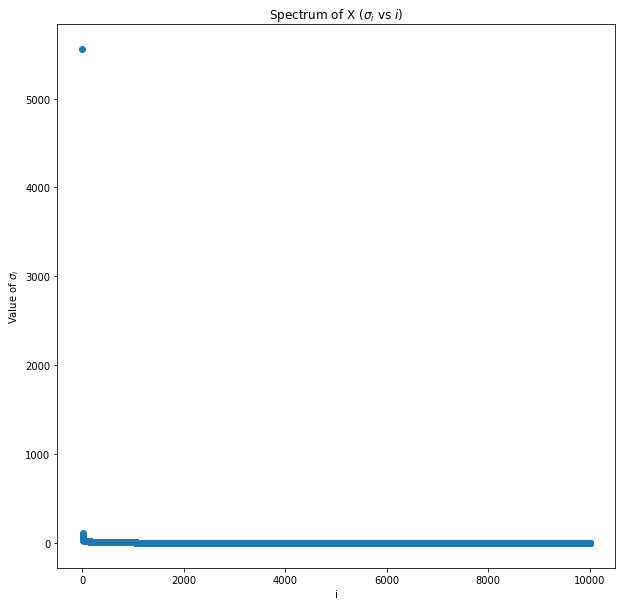

In [64]:
# Plot spectrum of x
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111) 
ax.scatter(range(len(sigma)), sigma)
ax.set_title('Spectrum of X ($\sigma_i$ vs $i$)')
ax.set_xlabel('i')
ax.set_ylabel('Value of $\sigma_i$')
plt.show()

In [51]:
# Using pseudoinverse of X when p >> n
def get_lw_w(x, y):
    
    # Calculate SVD of x
    u, sigma, vt = np.linalg.svd(x)
    
    # Calculate pseudoinverse of sigma
    k = x.shape[1]
    sigma_psinv = np.zeros((vt.shape[0], u.shape[0])) 
    sigma_psinv[:k, :k] = np.diag(1 / sigma[:k])
    
    # Calculate least squares weights
    w = np.linalg.multi_dot([
        vt.T, sigma_psinv, u.T, y
    ])
    
    return w    

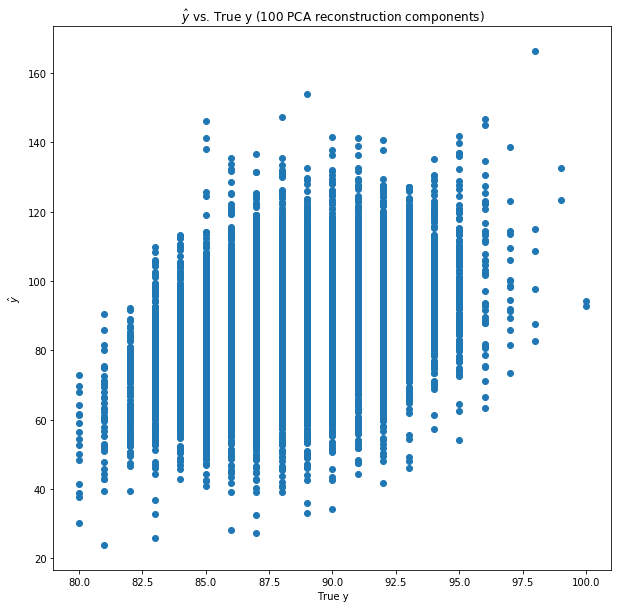

In [69]:
# Plot results
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111) 
ax.scatter(y_df, y_hat)
ax.set_title('$\hat{y}$ vs. True y (100 PCA reconstruction components)')
ax.set_xlabel('True y')
ax.set_ylabel('$\hat{y}$')
plt.show()

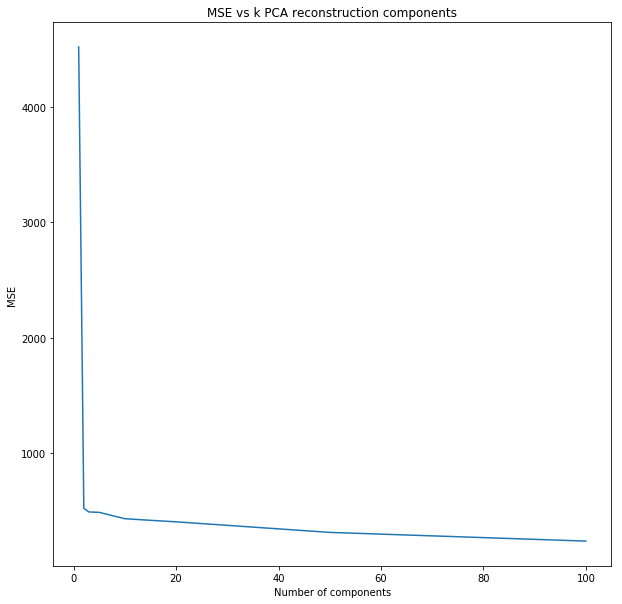

In [70]:
# Plot results
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111) 
ax.plot(k_vals, mse_k)
ax.set_title('MSE vs k PCA reconstruction components')
ax.set_xlabel('Number of components')
ax.set_ylabel('MSE')
plt.show()